In [1]:
import numpy as np
import pandas as pd
import time
import sys
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve,auc

In [2]:
#get data
in_file = '../../merge/reformatted_data_with_features.txt'
feature_type = 'downsampled'
metadata_columns = ['tumor_fraction','cancer_present','sample_type','Stage']

data = pd.read_csv(in_file, sep='\t')

data = data.set_index('sample')
data['status'] = data['cancer_present']

#get only the training samples used in delfi
training_samples = pd.read_csv("../../../../../metadata/cancer_detection/delfi_training_samples.txt", header=None)
data = data[data.index.isin(training_samples[0])].copy()

print(len(data))
print(data['sample_type'].value_counts())


423
Healthy              215
Breast_Cancer         54
Pancreatic_Cancer     34
Ovarian_Cancer        28
Gastric_cancer        27
Colorectal_Cancer     27
Bile_Duct_Cancer      25
Lung_Cancer           12
Duodenal_Cancer        1
Name: sample_type, dtype: int64


In [3]:
#view data
data.head()

,tumor_fraction,sample_type,cancer_present,Stage,central_cov_AHR.hg38,central_cov_AR.hg38,central_cov_ARID3A.hg38,central_cov_ARNT.hg38,central_cov_ARNTL.hg38,central_cov_ASCL1.hg38,...,mean_cov_ZNF554.hg38,mean_cov_ZNF574.hg38,mean_cov_ZNF580.hg38,mean_cov_ZNF652.hg38,mean_cov_ZNF770.hg38,mean_cov_ZNF792.hg38,mean_cov_ZSCAN16.hg38,mean_cov_ZSCAN22.hg38,mean_cov_ZSCAN9.hg38,status
sample,,,,,,,,,,,,,,,,,,,,,
Bile_Duct_Cancer_CGPLPA114,0.00000,Bile_Duct_Cancer,1,II,1.029662,1.100120,1.062652,0.957183,1.060820,0.980470,...,0.979889,0.912708,0.908832,0.958355,0.962240,0.917223,0.955240,0.903997,0.902060,1
Bile_Duct_Cancer_CGPLPA115,0.14790,Bile_Duct_Cancer,1,IV,1.000917,1.079883,1.026257,0.980915,1.072635,0.994850,...,0.989389,0.924775,0.923594,0.979478,0.967001,0.927367,0.965633,0.920879,0.928297,1
Bile_Duct_Cancer_CGPLPA117,0.00000,Bile_Duct_Cancer,1,II,0.950753,1.057923,0.947920,0.940712,1.011927,0.986433,...,0.985933,0.905755,0.912303,0.961418,0.969872,0.915388,0.955557,0.906355,0.916253,1
Bile_Duct_Cancer_CGPLPA118,0.03099,Bile_Duct_Cancer,1,I,0.993513,1.107450,1.013155,0.954433,1.039332,1.069753,...,0.980912,0.882582,0.902792,0.953448,0.961656,0.909943,0.945139,0.895477,0.902963,1
Bile_Duct_Cancer_CGPLPA122,0.04570,Bile_Duct_Cancer,1,II,0.953450,1.141615,0.959935,0.933580,1.100545,1.065015,...,0.964549,0.892644,0.892879,0.950364,0.954806,0.883292,0.937111,0.889646,0.885998,1


In [4]:
#get a list of all possible features
features = data.columns.drop(['status']+metadata_columns)

#these two should be the seame
print(len(features))
print(len(features[features.str.contains('fft_10_magnitude')])*3)

1014
1014


In [5]:
#scale data
scaler = StandardScaler()
scaler.fit(data[features])
data[features] = scaler.transform(data[features])
data[features].mean()

central_cov_AHR.hg38       2.492096e-16
central_cov_AR.hg38        3.540640e-16
central_cov_ARID3A.hg38    1.622553e-15
central_cov_ARNT.hg38     -1.492896e-15
central_cov_ARNTL.hg38    -1.351165e-15
                               ...     
mean_cov_ZNF770.hg38      -8.993048e-15
mean_cov_ZNF792.hg38      -1.216521e-15
mean_cov_ZSCAN16.hg38      1.566386e-15
mean_cov_ZSCAN22.hg38      2.343017e-15
mean_cov_ZSCAN9.hg38      -1.109856e-14
Length: 1014, dtype: float64

In [6]:
#Leave one out nested cross validation
hyperparameters = {'C': [0.00001, 0.0001, 0.001,0.01,0.1,1,10,100]}

start_time = time.time()
n_iter = 1000

probabilities = pd.DataFrame(index=data.index)
c_vals = []
coefs = pd.DataFrame(index=features)

# Loop for each iteration
for i in range(n_iter):
    if i%50==0:
        print(i, time.time()-start_time)
        sys.stdout.flush()
    
    #bootstrap a training set with replacement
    training = data.sample(len(data), replace = True, random_state = i+100)
    
    #the test set is all samples that aren't seen in the training data
    test = data[~(data.index.isin(training.index))]
        
    #10 fold cross validation on the training set
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state = i+100) 

    model = LogisticRegression(class_weight='balanced', max_iter=500)
    search = GridSearchCV(estimator=model, param_grid=hyperparameters, cv=cv, n_jobs = 1)
    search.fit(training[features], training['status'])
    best_C = search.best_params_['C']
    
    #train a new model on the full training dataset (is this the same as refit...?)
    model = LogisticRegression(class_weight='balanced', max_iter=500, C=best_C)
    model.fit(training[features], training['status'])

    #predict the test data
    pred = model.predict(test[features])
    prob = model.predict_proba(test[features])

    
    #collect metrics
    current_output = pd.DataFrame(test[['status']])#.reset_index()
    current_output['probability']=prob[:,1]
    
    #save results
    probabilities[i] = current_output['probability']
    c_vals.append(best_C)
    coefs[i] = pd.Series(model.coef_[0], index = features)

probabilities = probabilities.merge(data[metadata_columns+['status']], left_index=True, right_index=True)

0 0.0011141300201416016
50 51.66702198982239
100 104.42908501625061
150 160.44670796394348
200 211.24654412269592
250 260.3005590438843
300 313.7734091281891
350 369.20277094841003
400 424.1116769313812
450 477.3230390548706
500 533.5119988918304
550 586.0835452079773
600 635.5584938526154
650 689.3419420719147
700 743.6554269790649
750 794.8531901836395
800 848.9720661640167
850 901.4894671440125
900 955.8289442062378
950 1009.1890559196472


In [7]:
probabilities.to_csv(feature_type+'_results/probabilities.txt', sep='\t')
pd.Series(c_vals).to_csv(feature_type+'_results/c_values.txt', sep='\t', header = False, index=False)
coefs.to_csv(feature_type+'_results/coefs.txt', sep='\t')

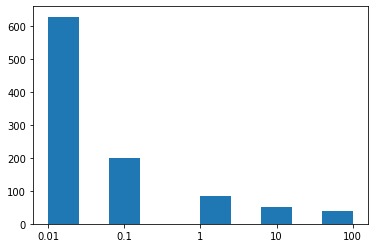

In [8]:
plt.hist([str(m) for m in sorted(c_vals)])
plt.savefig(feature_type+'_results/cvals.pdf')